In [3]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
from stanify.calibrator.draws_data_mapper import draws2data2draws
from stanify.calibrator.calib_utilities import check_consistency
import random
random.seed(10)
from bokeh.io import output_notebook
output_notebook()
import warnings
warnings.filterwarnings('ignore')

Loading BokehJS ...

##  developing model families using visual diagnostics and numeric summaries
If you run the user interface code which states input and output format as below, it creates specific model, data, plot (two `.stan`, two `.nc files, multiple plots) in three folders. With minimal number of clicks, your model quality can be inspected. This aim of this vignette is to inspect how given the two outputs (model and data) can be analyzed for your next move.

keyword: simulation-based calibration, pair plots, divergence, InferenceData

## user interface

In [2]:
precision ={
    "S": 1, # # of draws from prior
    "M": 50, # # of draws from posterior (# of chains * # of draws from each chain)
    "N": 201, # # of observation
    "R": 1, # # of subgroups for hierarchical Bayes
}

setting = {
    "est_param_names": ("prey_birth_frac", "pred_birth_frac"),
    "hier_est_param_names" : (),
    "target_simulated_vector_names": ("prey", "predator"),
    "driving_vector_names": ("process_noise_uniform_driving"),
    "model_name": "prey_predator",
}

numeric = {
    "process_noise_uniform_driving": np.random.uniform(low=-.5, high=.5, size = precision['N']),
    'process_noise_scale': 0.01
}

prior = {
    ("prey_birth_frac", "normal", 0.9, 0.001, 0),
    ("pred_birth_frac", "normal", 0.9, 0.001, 0),
    ("m_noise_scale", "normal", .01, .001, 0)
}

output_format = dict(
    prior_predictive=["prey_obs", "predator_obs"],
    posterior_predictive=["prey_obs_post", "predator_obs_post"],
    log_likelihood={
        "loglik": "loglik"
    },
    coords={
        "time": [n for n in range(precision['N'])],
        "stock": setting['target_simulated_vector_names'],
        "region": [r for r in range(precision['R'])]
    },
    dims={
        'initial_outcome': ["stock"],
        'integrated_result': ["time", "stock"],
        'prey': ["time"],
        'predator': ["time"],
        'process_noise': ["time"],
        "prey_obs": ["time"],
        "predator_obs": ["time"],
    }
)

if check_consistency(setting, precision, numeric, prior, output_format):
    model = draws2data2draws('../vensim_models/prey_predator/prey_predator.mdl', setting, precision, numeric, prior, output_format)

09:22:59 - cmdstanpy - INFO - compiling stan file /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/draws2data.stan to exe file /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/draws2data
09:23:14 - cmdstanpy - INFO - compiled model executable: /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/draws2data
09:23:14 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
09:23:14 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc --include-paths=/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1 --o=/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/draws2data.hpp /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/draws2data.stan
Warning in '/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/draws2data.stan', line 43, column 4: Declaration
    of arrays by pl

chain 1 |          | 00:00 Status

09:23:15 - cmdstanpy - INFO - CmdStan done processing.


09:23:19 - cmdstanpy - INFO - compiling stan file /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/data2draws.stan to exe file /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/data2draws
09:23:34 - cmdstanpy - INFO - compiled model executable: /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/data2draws
09:23:34 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
09:23:34 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc --include-paths=/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1 --o=/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/data2draws.hpp /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/data2draws.stan
Warning in '/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/data2draws.stan', line 47, column 4: Declaration
    of arrays by pl

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

10:57:53 - cmdstanpy - ERROR - CmdStan error: terminated by signal 2 Unknown error: -2


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x14eb61240> (for post_execute):


KeyboardInterrupt: 

We load the produced data for plotting. Please refer to the end of this document for model (stan code) and data structure which is Stanify's main contribution, but not the scope here.

In [4]:
modelname = "prey_predator_S1N201Q2R1"
draws2data = az.from_netcdf(f"data/{modelname}/draws2data.nc")
data2draws = az.from_netcdf(f"data/{modelname}/data2draws.nc")

In [5]:
sbc = az.from_netcdf(f"data/{modelname}/data2draws.nc")

## diagnose numerically with InferenceData

`draws2data` have three groups: `prior`, `prior_predictive`, `samp_stats_prior`.First click the arrow to inspect dataset structure of each group. If you click database icon, it will show each data variable (estimated parameter, target simulated vectors for `prior` group, observed vector for `prior_predictive` group, lp and acceptance rate for `sample_stats_prior` group)

In [6]:
draws2data

Inference data with groups:
	> prior
	> prior_predictive
	> sample_stats_prior


`data2draws` have four groups: `posterior`, `prior_predictive`, `log_likelihood`, `samp_stats`. First click the arrow to inspect dataset structure of each group. If you click database icon, it will show each data variable (estimated parameter, target simulated vectors for `posterior` group, observed vector (adding measurement noise on target simulated vector posterior) for `prior_predictive` group, loglikelihood of each posterior sample for `log_likelihood`, lp, acceptance_rate, tree_depth, energy (HMC alg.parameters) `sample_stats_prior` group)

In [7]:
data2draws

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats

summary function returns mean, sd, credible interval for estimated parameter and target simulated vector. mcse, effective sample size (ess), r_hat tells quality of each variables' sample. Refer to [Stan manual](https://mc-stan.org/docs/reference-manual/effective-sample-size.html) for ess details.

In [8]:
az.summary(data2draws)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_birth_frac,0.069,0.020,0.049,0.088,0.011,0.009,3.0,3.0,inf
prey_birth_frac,0.312,0.058,0.255,0.370,0.033,0.026,3.0,3.0,inf
m_noise_scale,0.545,0.028,0.517,0.573,0.016,0.013,3.0,3.0,inf
predator[0.01],4.051,0.024,4.027,4.075,0.014,0.011,3.0,3.0,inf
predator[0.135],4.768,0.377,4.395,5.142,0.218,0.172,3.0,3.0,inf
...,...,...,...,...,...,...,...,...,...
"integrated_result[24.885, prey]",15.013,14.001,1.153,28.878,8.084,6.388,3.0,3.0,2.62
"integrated_result[24.885, process_noise]",0.013,0.000,0.012,0.013,0.000,0.000,8.0,6.0,2.29
"integrated_result[25.01, predator]",4.044,0.175,3.868,4.217,0.101,0.080,3.0,6.0,2.62
"integrated_result[25.01, prey]",15.351,14.338,1.158,29.550,8.278,6.541,3.0,3.0,2.62


## Diagnose visually with time series, trace, pair, rank plots

### time series of target simulated and its measurement noise added observed vector

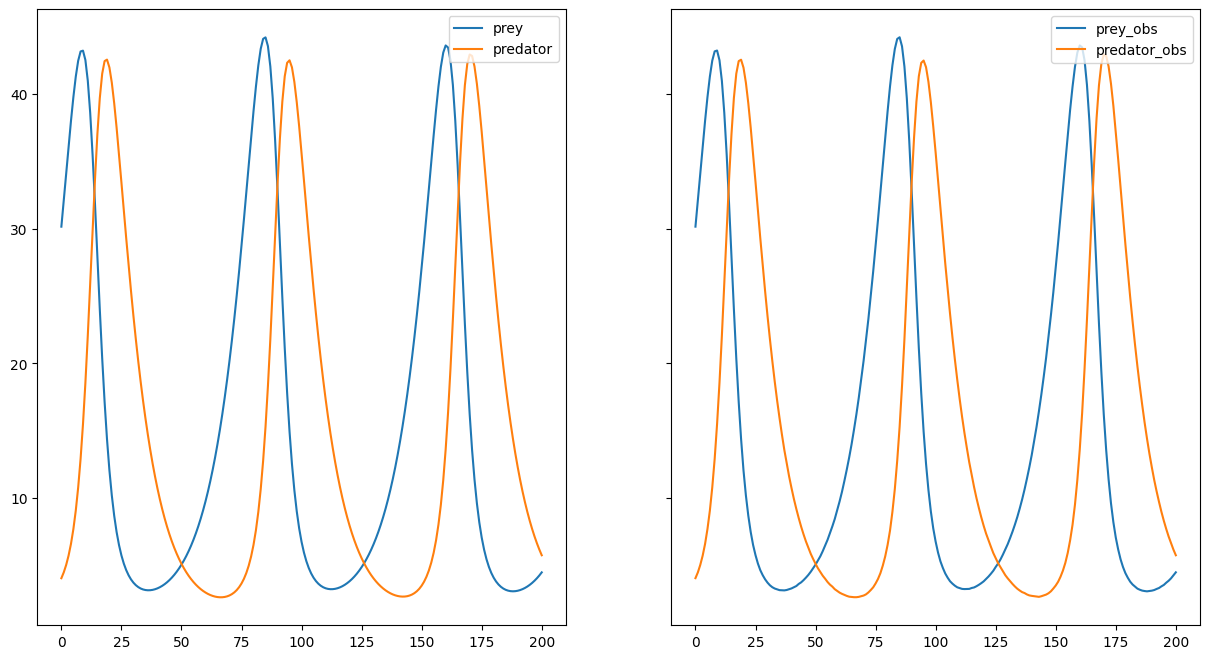

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), sharey=True)

for target in ['prey', 'predator']:
    ax1.plot(draws2data.prior[target].mean('prior_draw').to_dataframe().values, label=f"{target}")
ax1.legend(loc= 'upper right')

for target in ['prey', 'predator']:
    ax2.plot(draws2data.prior_predictive[f'{target}_obs'].mean('prior_draw').to_dataframe().values, label=f"{target}_obs")
ax2.legend(loc= 'upper right')


### trace plot
shows estiamted prameters are not well-mixed between chains

array([[<AxesSubplot: title={'center': 'pred_birth_frac'}>,
        <AxesSubplot: title={'center': 'pred_birth_frac'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot: title={'center': 'prey_birth_frac'}>,
        <AxesSubplot: title={'center': 'prey_birth_frac'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

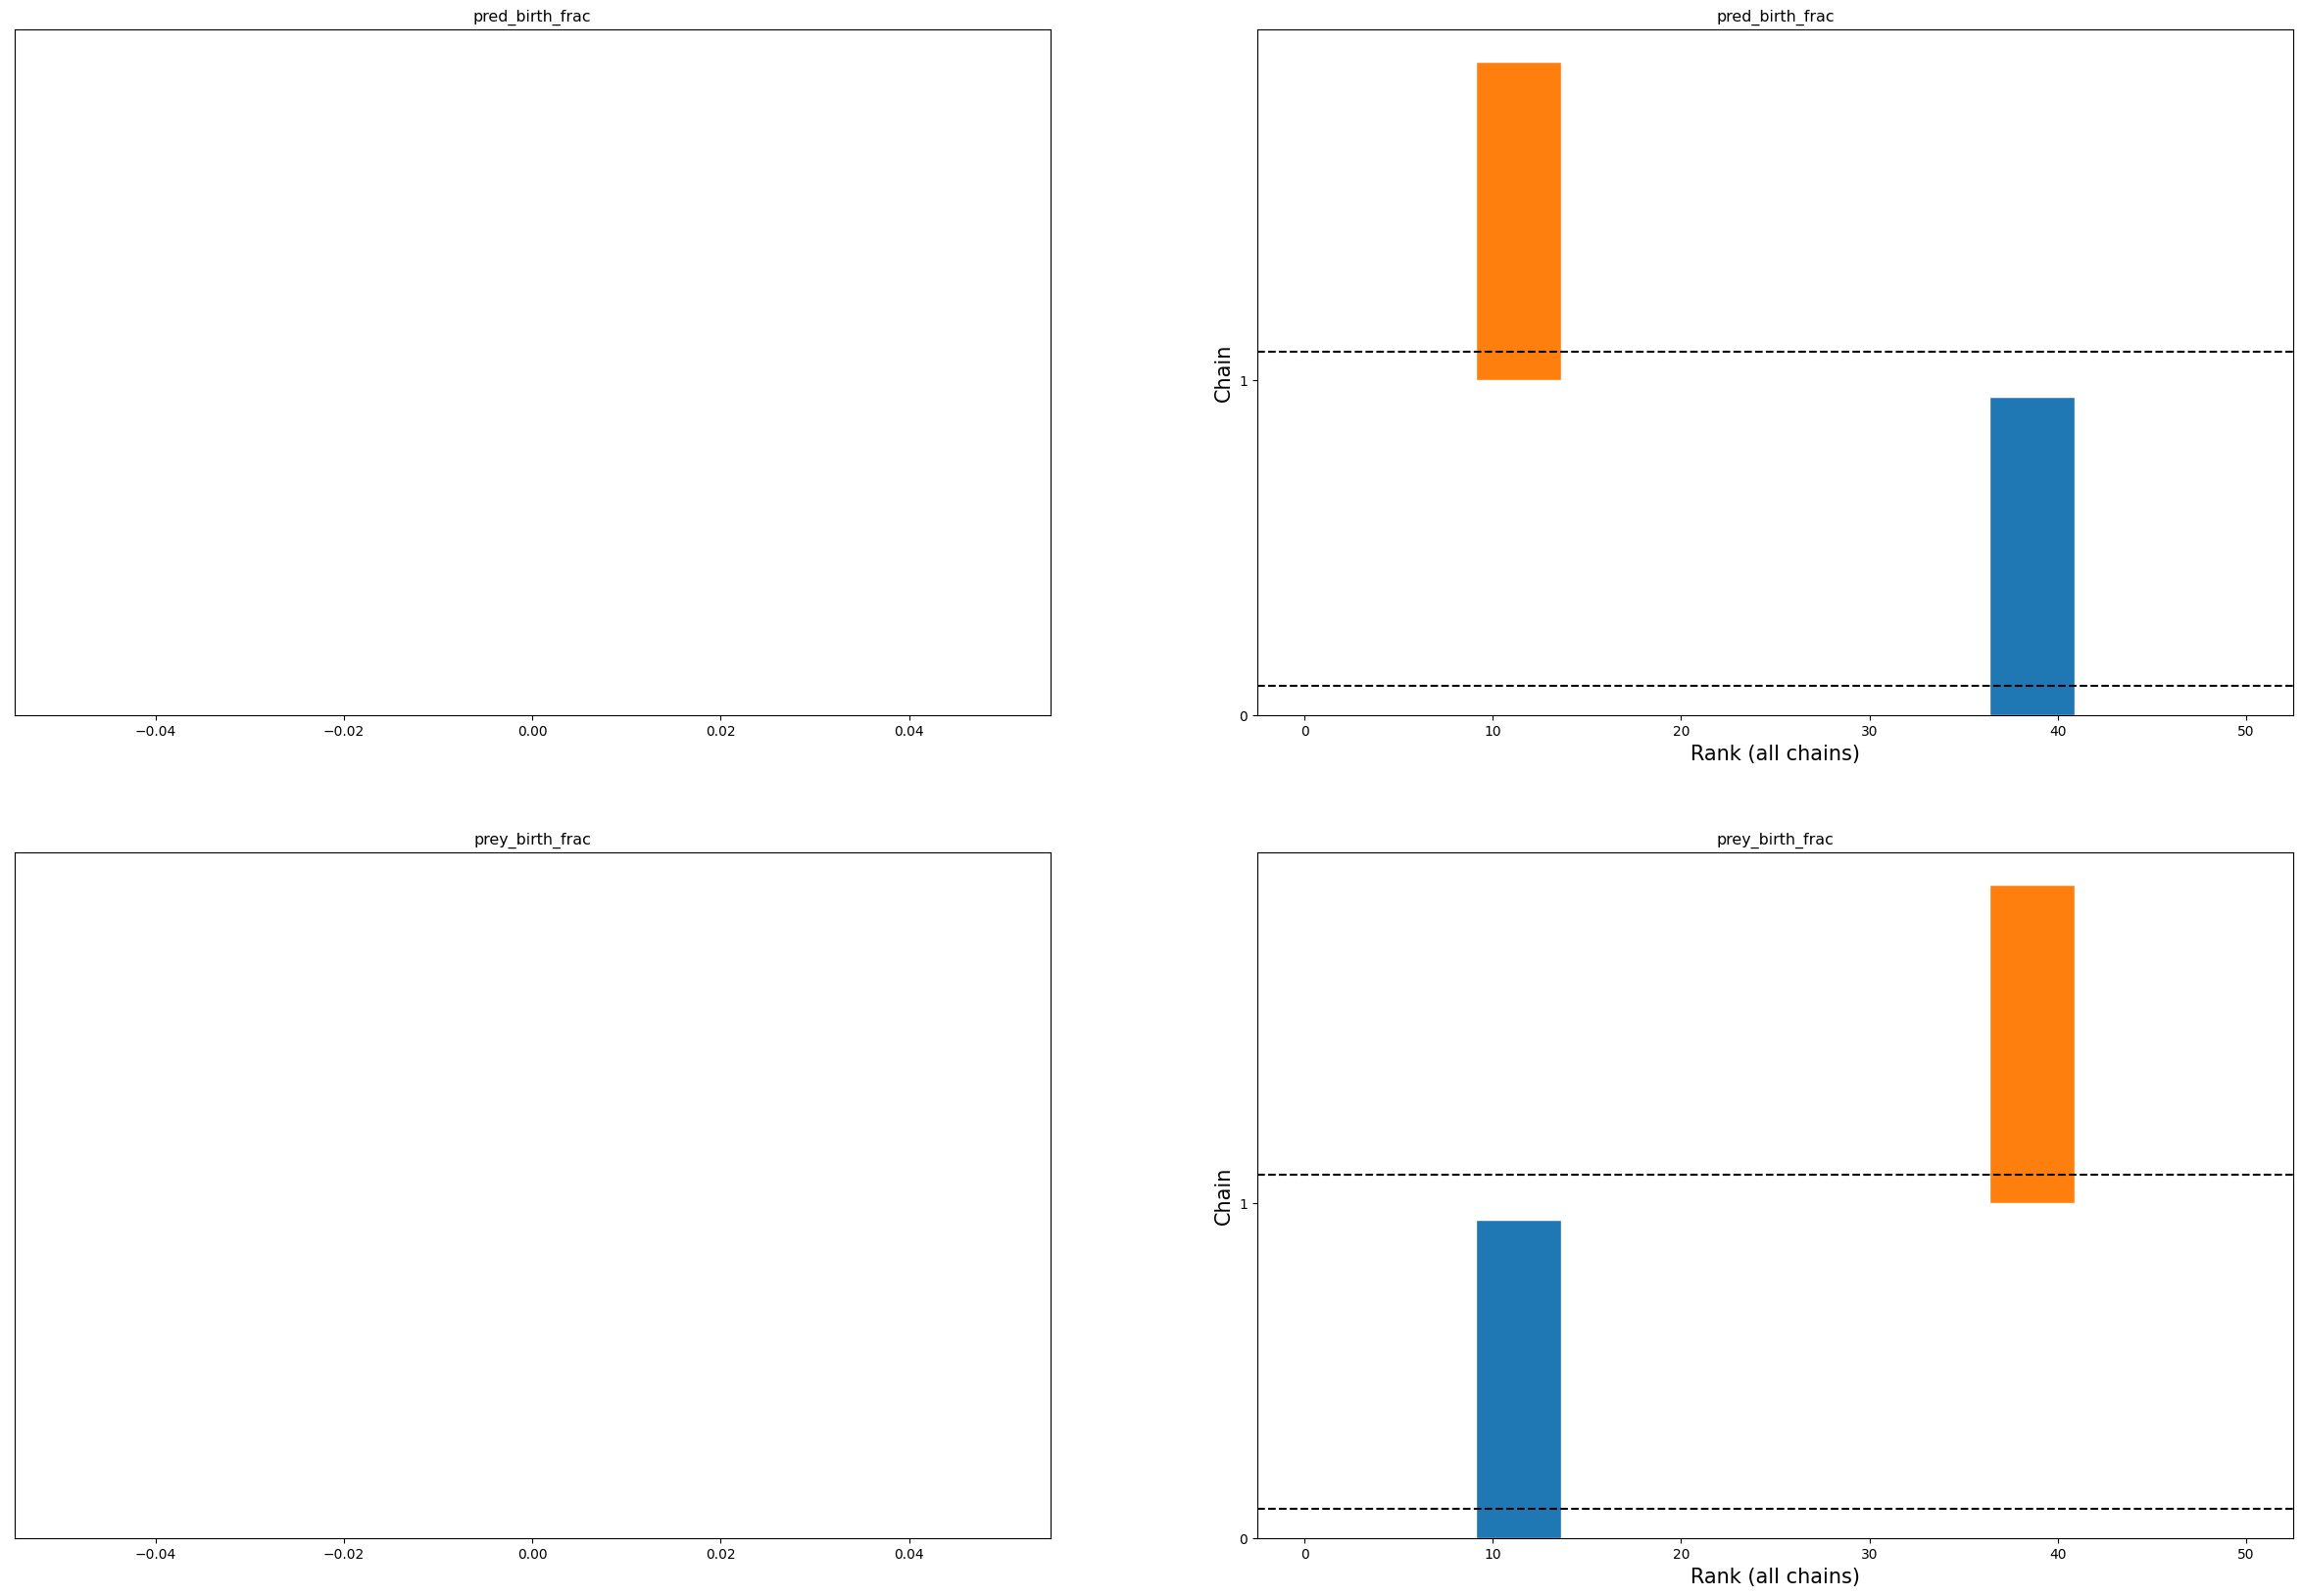

In [10]:
az.plot_trace(data2draws, figsize= (30, 20), var_names= ['pred_birth_frac', 'prey_birth_frac'], kind = "rank_bars")

### pair plot focused and all

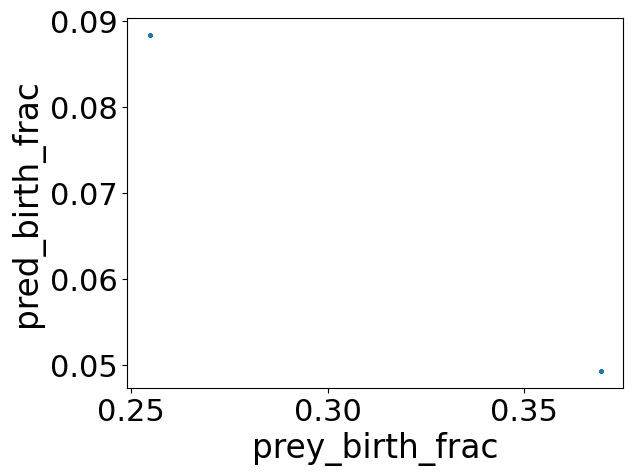

In [11]:
ax = az.plot_pair(data2draws,  var_names=['prey_birth_frac', 'pred_birth_frac'], divergences=True, textsize=22,)

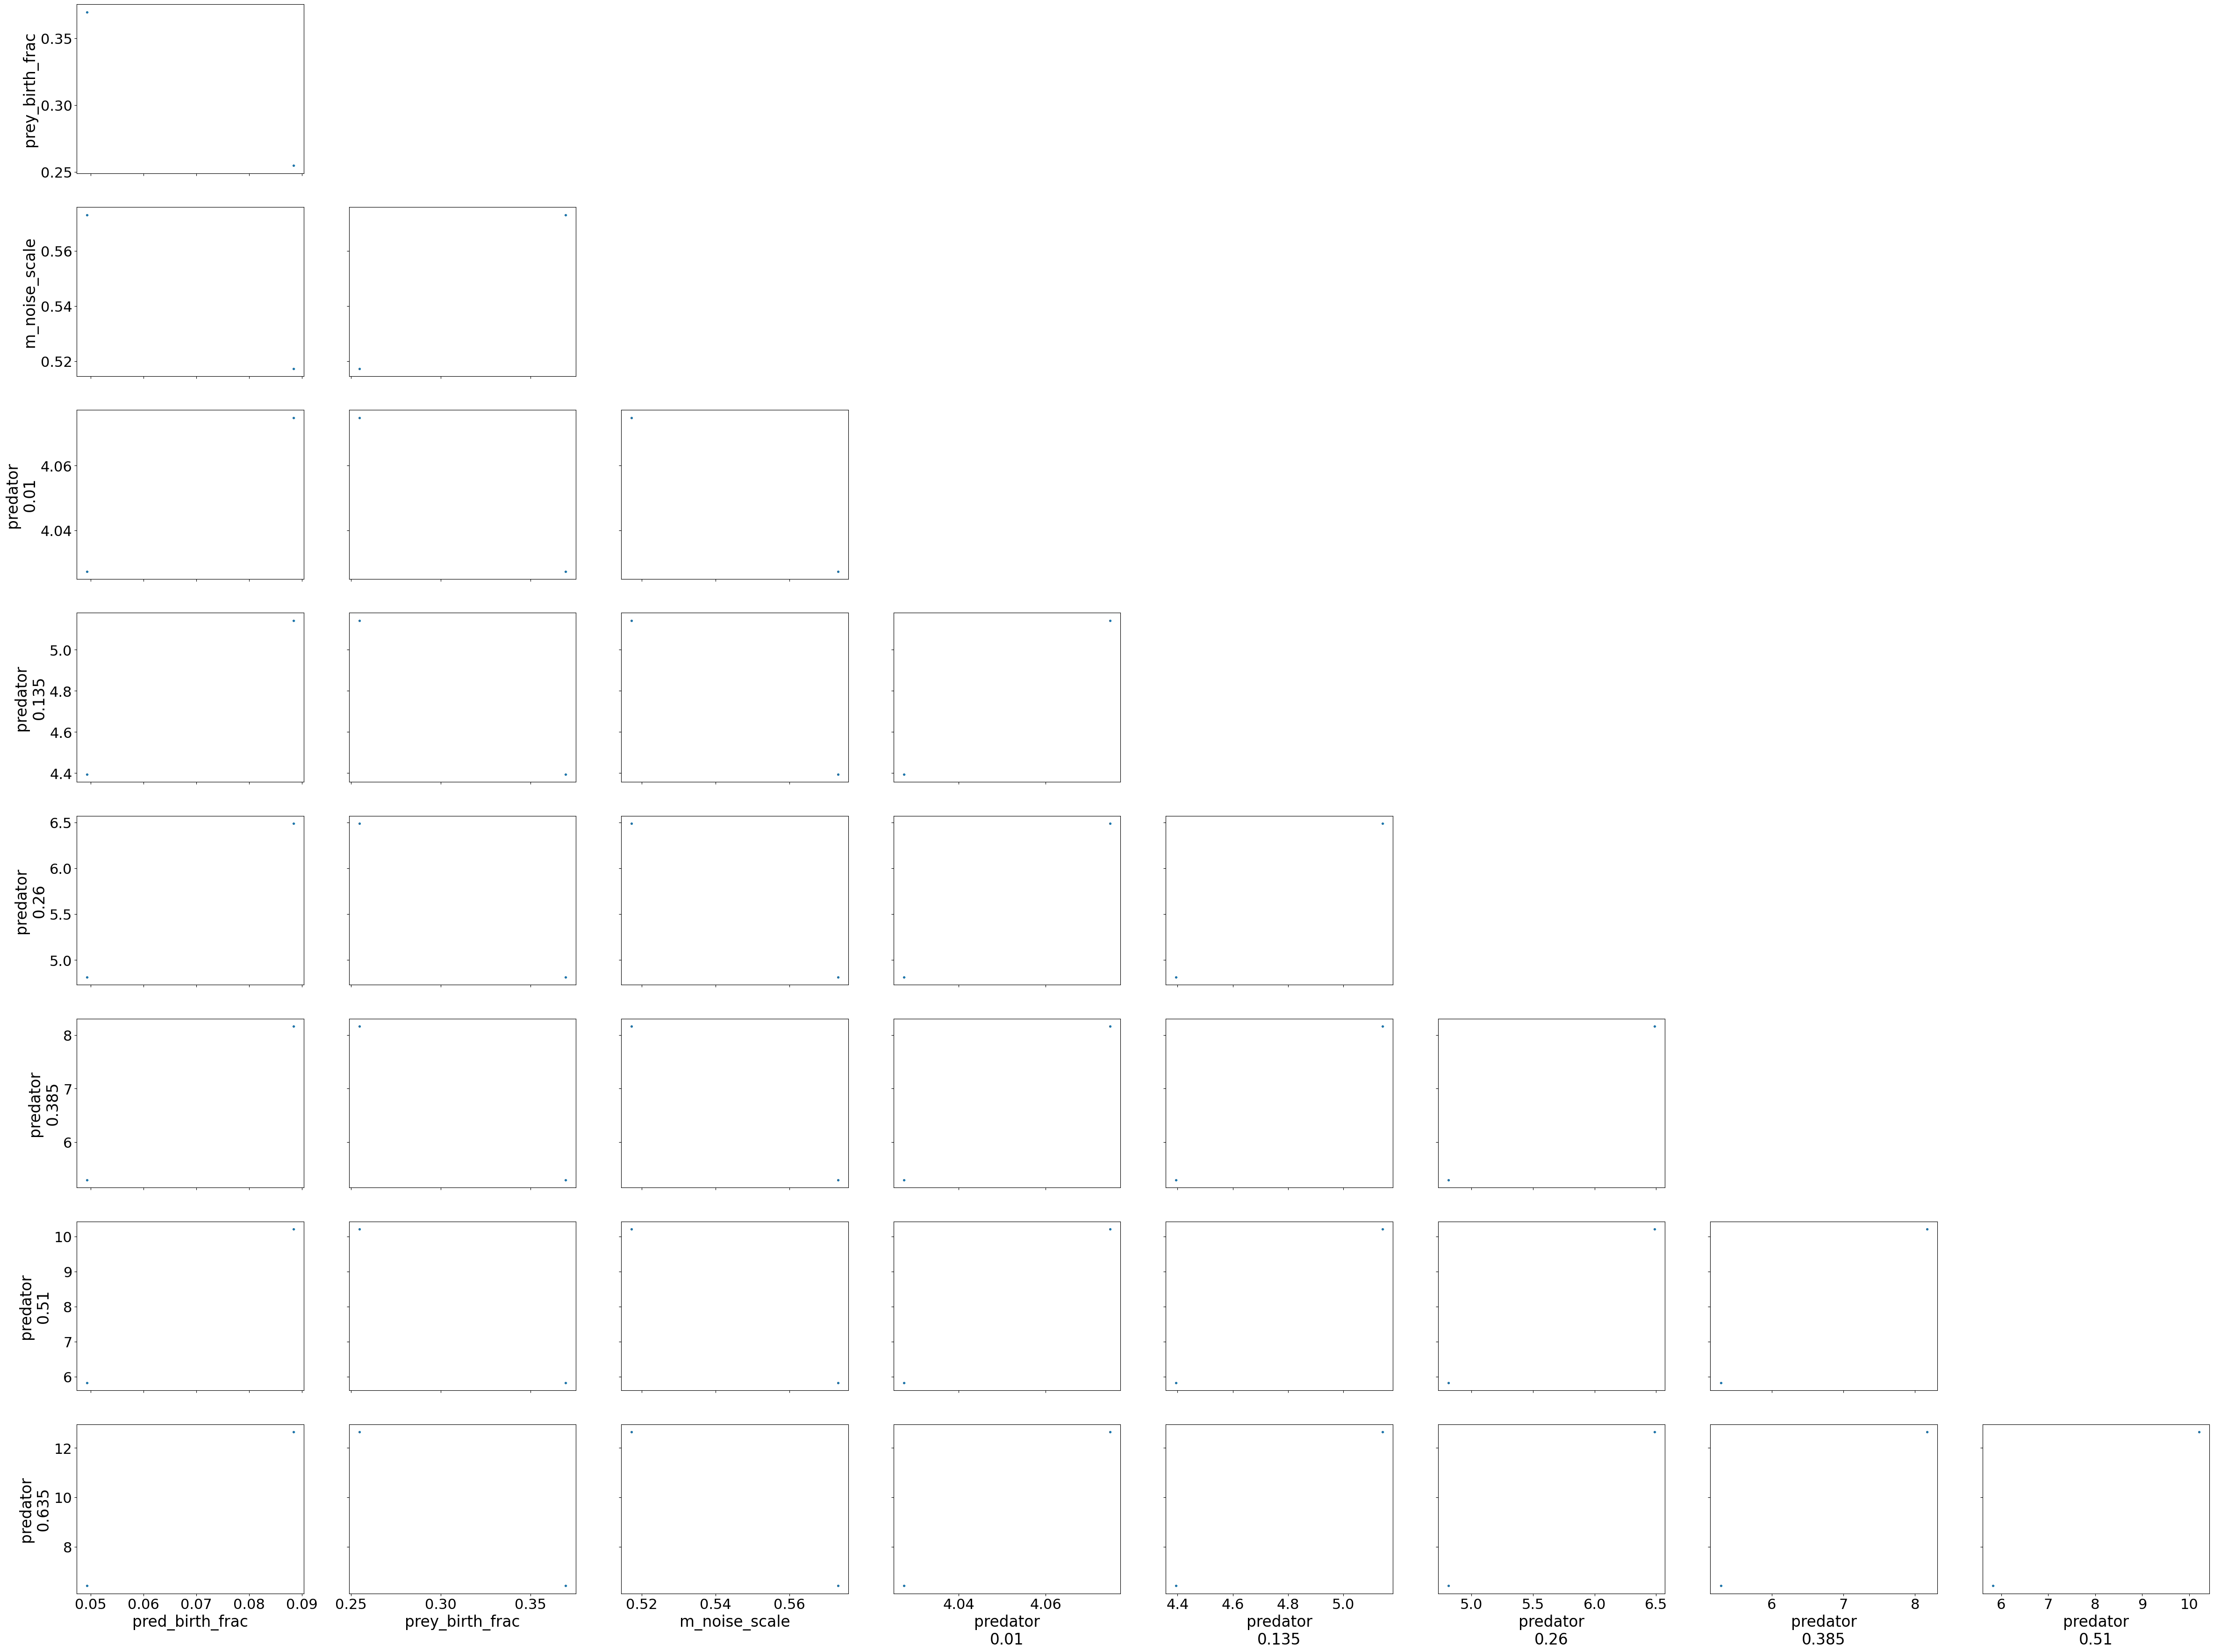

In [12]:
ax = az.plot_pair(data2draws,  divergences=True, textsize=22,) #, backend="bokeh" for interactive plot

### rank plot
indicates more than one peak

array([<AxesSubplot: title={'center': 'prey_birth_frac'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <AxesSubplot: title={'center': 'pred_birth_frac'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

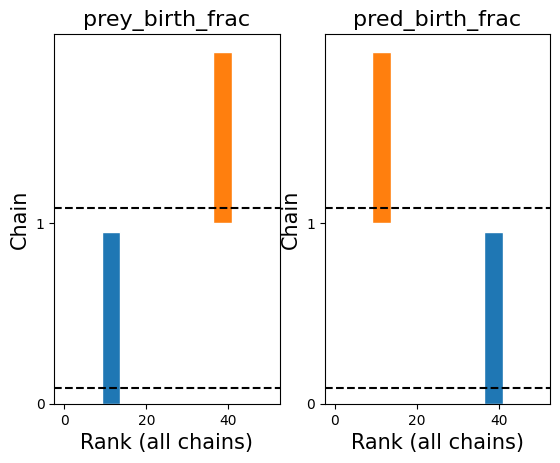

In [13]:
fig, axes = plt.subplots(1, 2)
az.plot_rank(data2draws, var_names=("prey_birth_frac", "pred_birth_frac"), ax=axes)

In [14]:
sbc

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats


# Appendix

## model

In [14]:
print(CmdStanModel(stan_file=f"stan_files/{model.name}/draws2data.stan").code())
print(CmdStanModel(stan_file=f"stan_files/{model.name}/data2draws.stan").code())

functions{
  #include functions.stan
}

data{
    int <lower=0> S;  // # of draws from prior 
    int <lower=0> M;  // # of draws from posterior (# of chains * # of draws from each chain)
    int <lower=0> N;  // # of observation
    int <lower=0> Q;  // # of target_simulated_stock 
    int <lower=0> R;  // # of subgroups for hierarchical Bayes 
    real <lower=0> time_step;
    array[N] real integration_times;
    vector[200] process_noise_uniform_driving;
    real process_noise_scale;
}

transformed data {
    real initial_time = 0.0;

    // Initial ODE values
    real predator__init = 4;
    real prey__init = 30;
    real process_noise__init = 0;

    // Initialize ODE stock vector
    vector[3] initial_outcome; 
    initial_outcome[1] = predator__init;
    initial_outcome[2] = prey__init;
    initial_outcome[3] = process_noise__init;
}

generated quantities{
    real prey_birth_frac = normal_rng(0.8, 0.08);
    real pred_birth_frac[R] =  normal_rng(rep_vector(0.05, R), 0.005);
   

16:28:45 - cmdstanpy - INFO - compiling stan file /Users/hyunjimoon/Dropbox/stanify/stan_files/prey_predator_S1M10N200Q2R2/data2draws.stan to exe file /Users/hyunjimoon/Dropbox/stanify/stan_files/prey_predator_S1M10N200Q2R2/data2draws
16:28:56 - cmdstanpy - INFO - compiled model executable: /Users/hyunjimoon/Dropbox/stanify/stan_files/prey_predator_S1M10N200Q2R2/data2draws


functions{
    #include functions.stan
}

data{
    int <lower=0> S;  // # of draws from prior 
    int <lower=0> M;  // # of draws from posterior (# of chains * # of draws from each chain)
    int <lower=0> N;  // # of observation
    int <lower=0> Q;  // # of target_simulated_stock 
    int <lower=0> R;  // # of subgroups for hierarchical Bayes 
    real <lower=0> time_step;
    array[N] real integration_times;
    vector[200] process_noise_uniform_driving;
    real process_noise_scale;
    array[N] vector[R] prey_obs;
    array[N] vector[R] predator_obs;
}

transformed data {
    real initial_time = 0.0;

    // Initial ODE values
    real predator__init = 4;
    real prey__init = 30;
    real process_noise__init = 0;

    // Initialize ODE stock vector
    vector[3] initial_outcome; 
    initial_outcome[1] = predator__init;
    initial_outcome[2] = prey__init;
    initial_outcome[3] = process_noise__init;
}

parameters{
    real<lower=0> prey_birth_frac;
    array[R] real<lower=0> 